## **Pip install packages**

In [34]:
!pip install pydot

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [49]:
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


# **Classification Question PART A**

### **Model Imports and Basic Preprocessing**

In [4]:
import tensorflow
import pandas as pd
import time
import numpy as np
import pylab as plt
import multiprocessing as mp
import statistics

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback

# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('/Users/abhishekvaidyanathan/Desktop/NNDL/features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [6]:
df['label'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64

In [7]:
print("Number of categories: ", df['label'].nunique())
print("The categories are: ", df["label"].unique())

Number of categories:  10
The categories are:  ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [8]:
columns_to_drop = ['label','filename', 'length']

def prepare_dataset(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    #scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test

In [9]:
X_train, y_train, X_test, y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(700, 57) (700,)
(300, 57) (300,)


### **QUESTION 1**

In [12]:
class time_for_batch(Callback):
    def on_train_begin(self, logs={}):
        self.times=[]
    def on_train_batch_begin(self, batch, logs={}):
        self.starttime = time.time()
    def on_train_batch_end(self, batch, logs={}):
        self.times.append(time.time()-self.starttime)
        
class time_for_epoch(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [9]:
def feed_forward_network():
  hidden_neurons = 16

  model = Sequential()
  model.add(Dense(hidden_neurons, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  history = model.fit(X_train, y_train,
                      batch_size=1,
                      epochs=50,
                      verbose=2,
                      use_multiprocessing=False,
                      validation_data=(X_test, y_test))
  return history

In [10]:
feed_forward_network_results = feed_forward_network()

2021-10-07 22:31:30.952170: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-07 22:31:31.233449: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
700/700 - 1s - loss: 2.1160 - accuracy: 0.2486 - val_loss: 1.6391 - val_accuracy: 0.4267
Epoch 2/50
700/700 - 1s - loss: 1.5786 - accuracy: 0.4329 - val_loss: 1.4016 - val_accuracy: 0.5000
Epoch 3/50
700/700 - 1s - loss: 1.4530 - accuracy: 0.4657 - val_loss: 1.2843 - val_accuracy: 0.5500
Epoch 4/50
700/700 - 1s - loss: 1.2794 - accuracy: 0.5171 - val_loss: 1.2007 - val_accuracy: 0.5700
Epoch 5/50
700/700 - 1s - loss: 1.1844 - accuracy: 0.5857 - val_loss: 1.1555 - val_accuracy: 0.5800
Epoch 6/50
700/700 - 0s - loss: 1.1757 - accuracy: 0.5614 - val_loss: 1.1095 - val_accuracy: 0.5767
Epoch 7/50
700/700 - 0s - loss: 1.1173 - accuracy: 0.5800 - val_loss: 1.1002 - val_accuracy: 0.6100
Epoch 8/50
700/700 - 0s - loss: 1.0357 - accuracy: 0.6229 - val_loss: 1.0621 - val_accuracy: 0.6267
Epoch 9/50
700/700 - 0s - loss: 1.0033 - accuracy: 0.6314 - val_loss: 1.0599 - val_accuracy: 0.6433
Epoch 10/50
700/700 - 1s - loss: 1.0199 - accuracy: 0.6200 - val_loss: 1.0593 - val_accuracy: 0.6267

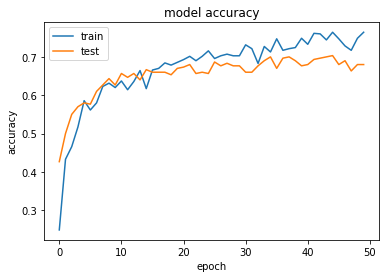

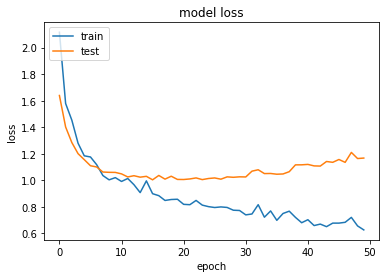

In [11]:
plt.figure(1)
plt.plot(feed_forward_network_results.history['accuracy'])
plt.plot(feed_forward_network_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(2)
plt.plot(feed_forward_network_results.history['loss'])
plt.plot(feed_forward_network_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **QUESTION 2**

In [13]:
def K_fold_cross_validation(no_folds,no_epochs,batch_size,X,Y,hidden_neurons,epoch_times_dict):
  print("Model training for:")
  print("Batch size",batch_size)
  print("Number of epcohs:" ,no_epochs)
  print("No folds used for k-fold cross validation:", no_folds)
  print("")

  kf = KFold(n_splits=no_folds,random_state=None, shuffle=False)
  KFold(n_splits=no_folds, random_state=None, shuffle=False)
  history_results = []
  for train_index, test_index in kf.split(X_train):
      X_train_K, X_test_K = X[train_index], X[test_index]
      y_train_K, y_test_K = Y[train_index], Y[test_index]

      model = Sequential()
      model.add(Dense(hidden_neurons, activation='relu'))
      model.add(Dropout(0.3))
      model.add(Dense(10, activation='softmax'))

      model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

      tb = time_for_batch()
      te = time_for_epoch()

      history = model.fit(X_train_K, y_train_K,
                          batch_size=batch_size,
                          epochs=no_epochs,
                          verbose=2,
                          use_multiprocessing=False,
                          callbacks = [tb, te],
                          validation_data=(X_test_K, y_test_K))
      epoch_times_dict[batch_size] = te.times
      print("")
      history_results.append(history)

  return history_results


In [14]:
Batch_sizes = [1,4,8,16,32, 64]
model_results = {}
epoch_times_dict = {}
for size in Batch_sizes:
  history = K_fold_cross_validation(3,50,size,X_train,y_train,16,epoch_times_dict)
  model_results[size] = history

Model training for:
Batch size 1
Number of epcohs: 50
No folds used for k-fold cross validation: 3



2021-10-11 01:18:28.998352: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
466/466 - 1s - loss: 2.2777 - accuracy: 0.1845 - val_loss: 1.8932 - val_accuracy: 0.3547
Epoch 2/50
466/466 - 1s - loss: 1.7845 - accuracy: 0.3412 - val_loss: 1.6237 - val_accuracy: 0.4444
Epoch 3/50
466/466 - 0s - loss: 1.5859 - accuracy: 0.4163 - val_loss: 1.4766 - val_accuracy: 0.4829
Epoch 4/50
466/466 - 0s - loss: 1.3961 - accuracy: 0.4979 - val_loss: 1.3650 - val_accuracy: 0.5085
Epoch 5/50
466/466 - 0s - loss: 1.3125 - accuracy: 0.5279 - val_loss: 1.2966 - val_accuracy: 0.5598
Epoch 6/50
466/466 - 0s - loss: 1.2680 - accuracy: 0.5279 - val_loss: 1.2609 - val_accuracy: 0.5342
Epoch 7/50
466/466 - 0s - loss: 1.2487 - accuracy: 0.5601 - val_loss: 1.2205 - val_accuracy: 0.5556
Epoch 8/50
466/466 - 0s - loss: 1.1314 - accuracy: 0.5794 - val_loss: 1.1800 - val_accuracy: 0.5769
Epoch 9/50
466/466 - 0s - loss: 1.1647 - accuracy: 0.5794 - val_loss: 1.1681 - val_accuracy: 0.5897
Epoch 10/50
466/466 - 1s - loss: 1.0464 - accuracy: 0.6030 - val_loss: 1.1123 - val_accuracy: 0.6368

In [18]:
median_times = []
for key in epoch_times_dict:
  epoch_times_dict[key] = statistics.median(epoch_times_dict[key])
  median_times.append(epoch_times_dict[key])

median_times_dataframe = pd.DataFrame()
median_times_dataframe['Batch_sizes'] = Batch_sizes
median_times_dataframe['median_epoch_times'] = median_times
median_times_dataframe

,Batch_sizes,median_epoch_times
0,1,0.371066
1,4,0.163667
2,8,0.076289
3,16,0.049806
4,32,0.031891
5,64,0.033807


In [76]:
model_results_accuracy = {}
model_results_validation_accuracy = {}
model_results_loss = {}
model_results_validation_loss = {}
for key in model_results:
    model_results_accuracy[key] = []
    model_results_validation_accuracy[key] = []
    model_results_loss[key] = []
    model_results_validation_loss[key] = []
    for results in model_results[key]:
        model_results_accuracy[key].append(results.history['accuracy'])
        model_results_validation_accuracy[key].append(results.history['val_accuracy'])
        model_results_loss[key].append(results.history['loss'])
        model_results_validation_loss[key].append(results.history['val_loss'])

In [77]:
for key in model_results_accuracy:
    model_results_accuracy[key] = np.asarray(model_results_accuracy[key]).mean(axis=0)
    model_results_validation_accuracy[key] = np.asarray(model_results_validation_accuracy[key]).mean(axis=0)
    model_results_loss[key] = np.asarray(model_results_loss[key]).mean(axis=0)
    model_results_validation_loss[key] = np.asarray(model_results_validation_loss[key]).mean(axis=0)

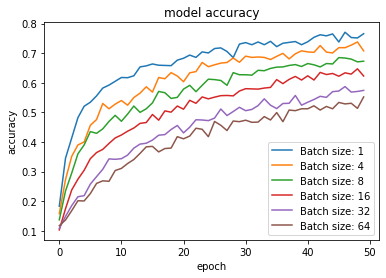

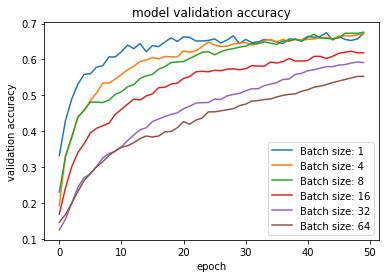

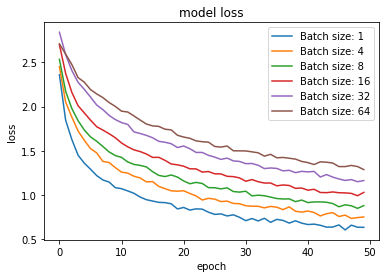

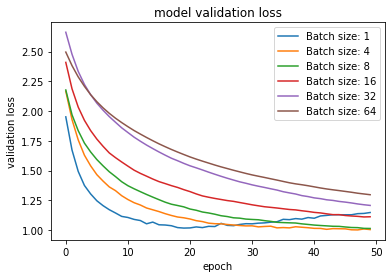

In [111]:
plt.figure(1)
key_array = []
for key in model_results_accuracy:
    plt.plot(model_results_accuracy[key])
    key_array.append("Batch size: "+str(key))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(key_array, loc='lower right')
plt.show()

plt.figure(2)
key_array = []
for key in model_results_validation_accuracy:
    plt.plot(model_results_validation_accuracy[key])
    key_array.append("Batch size: "+str(key))
plt.title('model validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(key_array, loc='lower right')
plt.show()

plt.figure(3)
key_array = []
for key in model_results_loss:
    plt.plot(model_results_loss[key])
    key_array.append("Batch size: "+str(key))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(key_array, loc='upper right')
plt.show()

plt.figure(4)
key_array = []
for key in model_results_validation_loss:
    plt.plot(model_results_validation_loss[key])
    key_array.append("Batch size: "+str(key))
plt.title('model validation loss')
plt.ylabel('validation loss')
plt.xlabel('epoch')
plt.legend(key_array, loc='upper right')
plt.show()

In [112]:
model_results_final_accuracy = {}
model_results_final_validation_accuracy = {}
model_results_final_loss = {}
model_results_final_validation_loss = {}
for key in model_results:
    model_results_final_accuracy[key] = max(model_results_accuracy[key])
    model_results_final_loss[key] = min(model_results_loss[key])
    model_results_final_validation_accuracy[key] = max(model_results_validation_accuracy[key])
    model_results_final_validation_loss[key] = min(model_results_validation_loss[key])

In [113]:
accuracies = []
validation_accuracies = []
loss = []
validation_loss = []
for key in model_results:
    accuracies.append(model_results_final_accuracy[key])
    validation_accuracies.append(model_results_final_validation_accuracy[key])
    loss.append(model_results_final_loss[key])
    validation_loss.append(model_results_final_validation_loss[key])

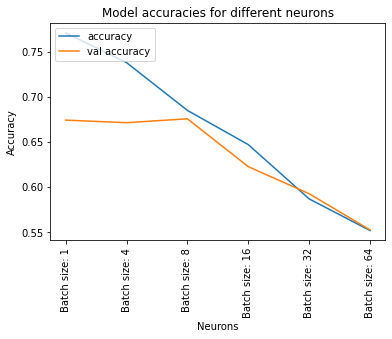

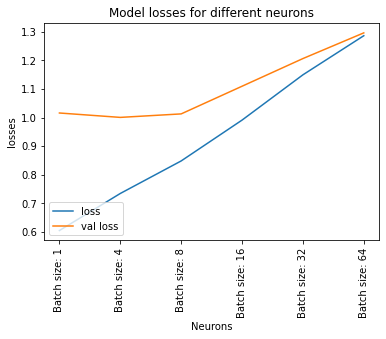

In [115]:
plt.figure(1)
plt.plot(key_array,accuracies,label="accuracy")
plt.plot(key_array,validation_accuracies,label="val accuracy")
plt.title('Model accuracies for different neurons')
plt.xlabel('Neurons')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
plt.legend(['accuracy', 'val accuracy'], loc='upper left') 
plt.show()

plt.figure(2)
plt.plot(key_array,loss,label="loss")
plt.plot(key_array,validation_loss,label="val loss")
plt.title('Model losses for different neurons')
plt.xlabel('Neurons')
plt.ylabel('losses')
plt.xticks(rotation=90) 
plt.legend(['loss', 'val loss'], loc='lower left') 
plt.show()

As we can see that with batch size 4 the validation loss is lower as well as the validation accuracy is higher. 

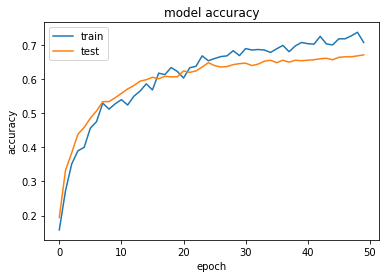

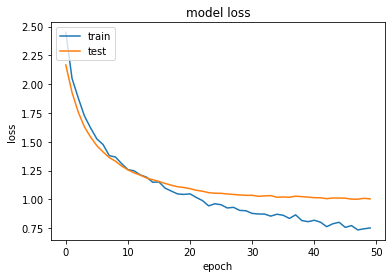

In [85]:
plt.figure(1)
plt.plot(model_results_accuracy[4])
plt.plot(model_results_validation_accuracy[4])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(2)
plt.plot(model_results_loss[4])
plt.plot(model_results_validation_loss[4])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **QUESTION 3**

In [92]:
def K_fold_cross_validation_neurons(no_folds,no_epochs,batch_size,X,Y,hidden_neurons,epoch_times_dict):
  print("Model training for:")
  print("Number of neurons",hidden_neurons)
  print("Number of epcohs:" ,no_epochs)
  print("No folds used for k-fold cross validation:", no_folds)
  print("")

  kf = KFold(n_splits=no_folds,random_state=None, shuffle=False)
  KFold(n_splits=no_folds, random_state=None, shuffle=False)
  history_results = []
  for train_index, test_index in kf.split(X_train):
      X_train_K, X_test_K = X[train_index], X[test_index]
      y_train_K, y_test_K = Y[train_index], Y[test_index]

      model = Sequential()
      model.add(Dense(hidden_neurons, activation='relu'))
      model.add(Dropout(0.3))
      model.add(Dense(10, activation='softmax'))

      model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

      tb = time_for_batch()
      te = time_for_epoch()

      history = model.fit(X_train_K, y_train_K,
                          batch_size=batch_size,
                          epochs=no_epochs,
                          verbose=2,
                          use_multiprocessing=False,
                          callbacks = [tb, te],
                          validation_data=(X_test_K, y_test_K))
      epoch_times_dict[hidden_neurons] = te.times
      print("")
      history_results.append(history)
  return history_results

In [93]:
number_of_neurons = [8, 16, 32, 64]
epoch_times_dict_neurons = {}
model_results_neurons = {}
for neurons in number_of_neurons:
  history = K_fold_cross_validation_neurons(3,50,4,X_train,y_train,neurons,epoch_times_dict_neurons)
  model_results_neurons[neurons] = history

Model training for:
Number of neurons 8
Number of epcohs: 50
No folds used for k-fold cross validation: 3

Epoch 1/50
117/117 - 1s - loss: 2.4565 - accuracy: 0.1631 - val_loss: 2.1933 - val_accuracy: 0.2094
Epoch 2/50
117/117 - 0s - loss: 2.2062 - accuracy: 0.2167 - val_loss: 2.0581 - val_accuracy: 0.2778
Epoch 3/50
117/117 - 0s - loss: 2.0661 - accuracy: 0.2682 - val_loss: 1.9388 - val_accuracy: 0.3547
Epoch 4/50
117/117 - 0s - loss: 1.9821 - accuracy: 0.2790 - val_loss: 1.8470 - val_accuracy: 0.3675
Epoch 5/50
117/117 - 0s - loss: 1.8846 - accuracy: 0.3369 - val_loss: 1.7582 - val_accuracy: 0.3846
Epoch 6/50
117/117 - 0s - loss: 1.7967 - accuracy: 0.3691 - val_loss: 1.6875 - val_accuracy: 0.4145
Epoch 7/50
117/117 - 0s - loss: 1.7327 - accuracy: 0.3798 - val_loss: 1.6250 - val_accuracy: 0.4359
Epoch 8/50
117/117 - 0s - loss: 1.6752 - accuracy: 0.3884 - val_loss: 1.5766 - val_accuracy: 0.4530
Epoch 9/50
117/117 - 0s - loss: 1.6615 - accuracy: 0.3820 - val_loss: 1.5257 - val_accuracy: 

In [94]:
model_results_neurons_accuracy = {}
model_results_neurons_validation_accuracy = {}
model_results_neurons_loss = {}
model_results_neurons_validation_loss = {}
for key in model_results_neurons:
    model_results_neurons_accuracy[key] = []
    model_results_neurons_validation_accuracy[key] = []
    model_results_neurons_loss[key] = []
    model_results_neurons_validation_loss[key] = []
    for results in model_results_neurons[key]:
        model_results_neurons_accuracy[key].append(results.history['accuracy'])
        model_results_neurons_validation_accuracy[key].append(results.history['val_accuracy'])
        model_results_neurons_loss[key].append(results.history['loss'])
        model_results_neurons_validation_loss[key].append(results.history['val_loss'])

In [96]:
for key in model_results_neurons_accuracy:
    model_results_neurons_accuracy[key] = np.asarray(model_results_neurons_accuracy[key]).mean(axis=0)
    model_results_neurons_validation_accuracy[key] = np.asarray(model_results_neurons_validation_accuracy[key]).mean(axis=0)
    model_results_neurons_loss[key] = np.asarray(model_results_neurons_loss[key]).mean(axis=0)
    model_results_neurons_validation_loss[key] = np.asarray(model_results_neurons_validation_loss[key]).mean(axis=0)

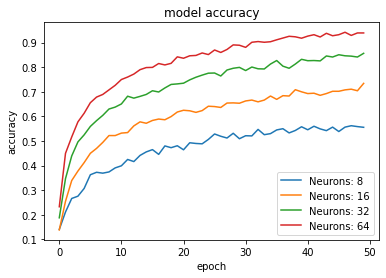

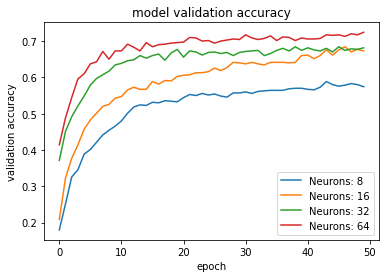

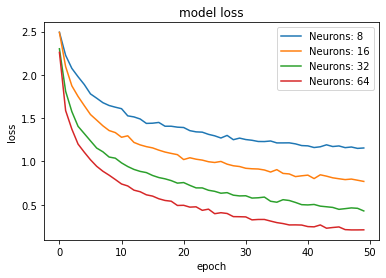

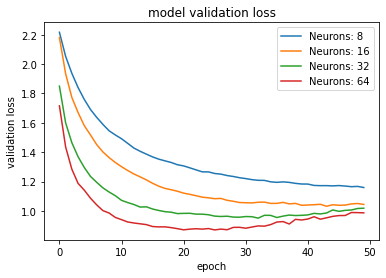

In [97]:
plt.figure(1)
key_array = []
for key in model_results_neurons_accuracy:
    plt.plot(model_results_neurons_accuracy[key])
    key_array.append("Neurons: "+str(key))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(key_array, loc='lower right')
plt.show()

plt.figure(2)
key_array = []
for key in model_results_neurons_validation_accuracy:
    plt.plot(model_results_neurons_validation_accuracy[key])
    key_array.append("Neurons: "+str(key))
plt.title('model validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(key_array, loc='lower right')
plt.show()

plt.figure(3)
key_array = []
for key in model_results_neurons_loss:
    plt.plot(model_results_neurons_loss[key])
    key_array.append("Neurons: "+str(key))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(key_array, loc='upper right')
plt.show()

plt.figure(4)
key_array = []
for key in model_results_neurons_validation_loss:
    plt.plot(model_results_neurons_validation_loss[key])
    key_array.append("Neurons: "+str(key))
plt.title('model validation loss')
plt.ylabel('validation loss')
plt.xlabel('epoch')
plt.legend(key_array, loc='upper right')
plt.show()

In [98]:
model_results_neurons_final_accuracy = {}
model_results_neurons_final_validation_accuracy = {}
model_results_neurons_final_loss = {}
model_results_neurons_final_validation_loss = {}
for key in model_results_neurons:
    model_results_neurons_final_accuracy[key] = max(model_results_neurons_accuracy[key])
    model_results_neurons_final_loss[key] = min(model_results_neurons_loss[key])
    model_results_neurons_final_validation_accuracy[key] = max(model_results_neurons_validation_accuracy[key])
    model_results_neurons_final_validation_loss[key] = min(model_results_neurons_validation_loss[key])

In [99]:
accuracies_neurons = []
validation_accuracies_neurons = []
loss_neurons = []
validation_loss_neurons = []
for key in model_results_neurons:
    accuracies_neurons.append(model_results_neurons_final_accuracy[key])
    validation_accuracies_neurons.append(model_results_neurons_final_validation_accuracy[key])
    loss_neurons.append(model_results_neurons_final_loss[key])
    validation_loss_neurons.append(model_results_neurons_final_validation_loss[key])

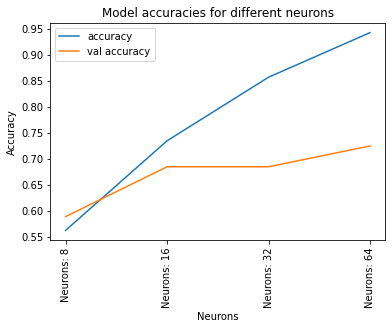

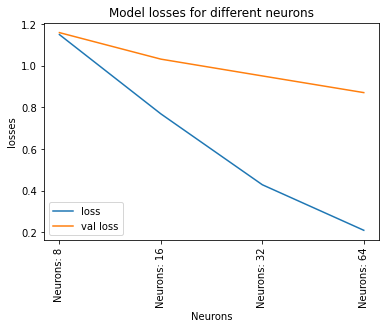

In [109]:
plt.figure(1)
plt.plot(key_array,accuracies_neurons,label="accuracy")
plt.plot(key_array,validation_accuracies_neurons,label="val accuracy")
plt.title('Model accuracies for different neurons')
plt.xlabel('Neurons')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
plt.legend(['accuracy', 'val accuracy'], loc='upper left') 
plt.show()

plt.figure(2)
plt.plot(key_array,loss_neurons,label="loss")
plt.plot(key_array,validation_loss_neurons,label="val loss")
plt.title('Model losses for different neurons')
plt.xlabel('Neurons')
plt.ylabel('losses')
plt.xticks(rotation=90) 
plt.legend(['loss', 'val loss'], loc='lower left') 
plt.show()

Using number of neurons 16 gives best possible model since the validation loss is low as well as the model has a validation accuracy of 72% with minimal overfitting when compared to other models using different number of neurons.

number of epochs can be tuned. Changing the dropout layer. WE ca also consider changing the train test split as well as using shuffling when implementing K-Fold.

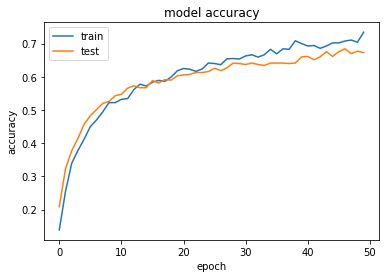

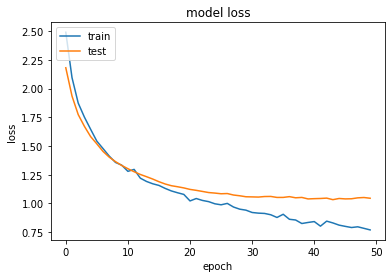

In [102]:
plt.figure(1)
plt.plot(model_results_neurons_accuracy[16])
plt.plot(model_results_neurons_validation_accuracy[16])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(2)
plt.plot(model_results_neurons_loss[16])
plt.plot(model_results_neurons_validation_loss[16])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **QUESTION 4**

In [24]:
def three_layer_K_fold_cross_validation(no_folds,no_epochs,batch_size,X,Y,hidden_neurons):

  kf = KFold(n_splits=no_folds,random_state=None, shuffle=False)
  KFold(n_splits=no_folds, random_state=None, shuffle=False)
  for train_index, test_index in kf.split(X_train):
      X_train_K, X_test_K = X[train_index], X[test_index]
      y_train_K, y_test_K = Y[train_index], Y[test_index]

      model = Sequential()
      model.add(Dense(hidden_neurons, activation='relu'))
      model.add(Dropout(0.3))
      model.add(Dense(hidden_neurons, activation='relu'))
      model.add(Dropout(0.3))
      model.add(Dense(10, activation='softmax'))

      model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

      tb = time_for_batch()
      te = time_for_epoch()

      history = model.fit(X_train_K, y_train_K,
                          batch_size=batch_size,
                          epochs=no_epochs,
                          verbose=2,
                          use_multiprocessing=False,
                          callbacks = [tb, te],
                          validation_data=(X_test_K, y_test_K))
      return history

In [27]:
three_layer_network_results = three_layer_K_fold_cross_validation(3,50,1,X_train,y_train,16)

Epoch 1/50
466/466 - 2s - loss: 2.3795 - accuracy: 0.1073 - val_loss: 2.0503 - val_accuracy: 0.2821
Epoch 2/50
466/466 - 1s - loss: 2.0607 - accuracy: 0.2253 - val_loss: 1.8592 - val_accuracy: 0.3205
Epoch 3/50
466/466 - 1s - loss: 1.9045 - accuracy: 0.3026 - val_loss: 1.7393 - val_accuracy: 0.3803
Epoch 4/50
466/466 - 1s - loss: 1.7887 - accuracy: 0.3734 - val_loss: 1.6406 - val_accuracy: 0.4231
Epoch 5/50
466/466 - 1s - loss: 1.7345 - accuracy: 0.3605 - val_loss: 1.5752 - val_accuracy: 0.4530
Epoch 6/50
466/466 - 0s - loss: 1.7108 - accuracy: 0.3541 - val_loss: 1.5096 - val_accuracy: 0.4915
Epoch 7/50
466/466 - 1s - loss: 1.5806 - accuracy: 0.4249 - val_loss: 1.4528 - val_accuracy: 0.4744
Epoch 8/50
466/466 - 0s - loss: 1.5635 - accuracy: 0.4077 - val_loss: 1.4045 - val_accuracy: 0.4915
Epoch 9/50
466/466 - 0s - loss: 1.4659 - accuracy: 0.4335 - val_loss: 1.3358 - val_accuracy: 0.5085
Epoch 10/50
466/466 - 0s - loss: 1.5105 - accuracy: 0.4356 - val_loss: 1.3213 - val_accuracy: 0.4915

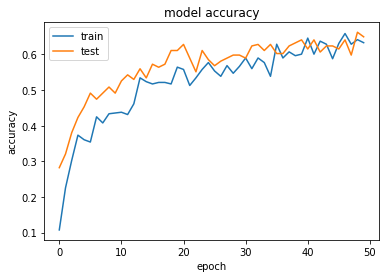

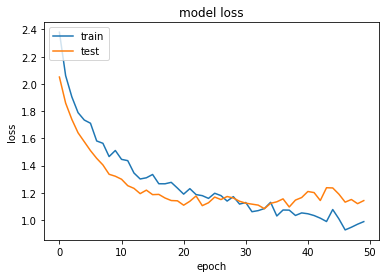

In [31]:
plt.figure(1)
plt.plot(three_layer_network_results.history['accuracy'])
plt.plot(three_layer_network_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(2)
plt.plot(three_layer_network_results.history['loss'])
plt.plot(three_layer_network_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
print("The results for the model with neurons size "+str(16)+" and batch size "+str(1))
print("train accuracy: ",max(three_layer_network_results.history['accuracy']))
print("validation accuracy: ",max(three_layer_network_results.history['val_accuracy']))
print("train loss: ",min(three_layer_network_results.history['loss']))
print("validation loss: ",min(three_layer_network_results.history['val_loss']))

The results for the model with neurons size 16 and batch size 1
train accuracy:  0.6587982773780823
validation accuracy:  0.6623931527137756
train loss:  0.9268597960472107
validation loss:  1.0829334259033203


From the above model results we can infer that the model with three layers i.e., with two hidden layers doesn't preform as good as the model with two layers, one hidden layer since both the validation accuracy and the validation loss or not as good as the model with two layers. 

### **QUESTION 5**


In [29]:
def two_layer_network_without_dropout():
    hidden_neurons = 16

    model = Sequential()
    model.add(Dense(hidden_neurons, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    tb = time_for_batch()
    te = time_for_epoch()

    history = model.fit(X_train, y_train,
                        batch_size=1,
                        epochs=50,
                        verbose=2,
                        use_multiprocessing=False,
                        callbacks = [tb, te],
                        validation_data=(X_test, y_test))
    return history

In [30]:
two_layer_network_without_dropout_results = two_layer_network_without_dropout()

Epoch 1/50
700/700 - 2s - loss: 1.9508 - accuracy: 0.3200 - val_loss: 1.6573 - val_accuracy: 0.3600
Epoch 2/50
700/700 - 1s - loss: 1.3678 - accuracy: 0.5114 - val_loss: 1.3648 - val_accuracy: 0.5033
Epoch 3/50
700/700 - 1s - loss: 1.1459 - accuracy: 0.6014 - val_loss: 1.2246 - val_accuracy: 0.5500
Epoch 4/50
700/700 - 1s - loss: 1.0165 - accuracy: 0.6286 - val_loss: 1.1593 - val_accuracy: 0.5767
Epoch 5/50
700/700 - 1s - loss: 0.9178 - accuracy: 0.6800 - val_loss: 1.1039 - val_accuracy: 0.6300
Epoch 6/50
700/700 - 1s - loss: 0.8391 - accuracy: 0.7157 - val_loss: 1.0582 - val_accuracy: 0.6400
Epoch 7/50
700/700 - 1s - loss: 0.7771 - accuracy: 0.7386 - val_loss: 1.0280 - val_accuracy: 0.6400
Epoch 8/50
700/700 - 1s - loss: 0.7234 - accuracy: 0.7643 - val_loss: 1.0126 - val_accuracy: 0.6500
Epoch 9/50
700/700 - 1s - loss: 0.6716 - accuracy: 0.7800 - val_loss: 0.9843 - val_accuracy: 0.6567
Epoch 10/50
700/700 - 1s - loss: 0.6277 - accuracy: 0.7943 - val_loss: 1.0123 - val_accuracy: 0.6600

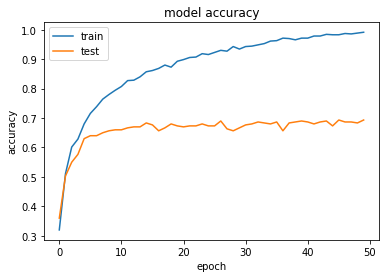

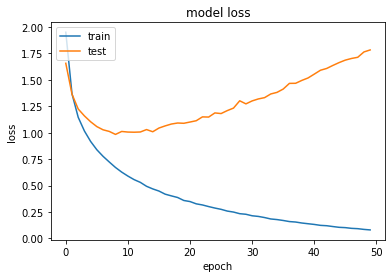

In [32]:
plt.figure(1)
plt.plot(two_layer_network_without_dropout_results.history['accuracy'])
plt.plot(two_layer_network_without_dropout_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(2)
plt.plot(two_layer_network_without_dropout_results.history['loss'])
plt.plot(two_layer_network_without_dropout_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
print("The results for the model with neurons size "+str(16)+" and batch size "+str(1))
print("train accuracy: ",max(two_layer_network_without_dropout_results.history['accuracy']))
print("validation accuracy: ",max(two_layer_network_without_dropout_results.history['val_accuracy']))
print("train loss: ",min(two_layer_network_without_dropout_results.history['loss']))
print("validation loss: ",min(two_layer_network_without_dropout_results.history['val_loss']))

The results for the model with neurons size 16 and batch size 1
train accuracy:  0.991428554058075
validation accuracy:  0.6933333277702332
train loss:  0.08091338723897934
validation loss:  0.9843373894691467


Removing dropouts resulted in the model overfitting on the training data. This will result in the model not performing well on new data while performing very well on train data. 

# **Regresssion Question PART B**

### **Package imports and Preprocessing**

In [1]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers,optimizers
import keras.backend as K
# from tensorflow.keras.layers import ...

from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [3]:
import pandas as pd
df = pd.read_csv('/Users/abhishekvaidyanathan/Desktop/NNDL/hdb_price_prediction.csv .csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [4]:
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### **QUESTION 1**

In [5]:
train_data = df[df['year']<=2020]
test_data = df[df['year']>2020]

In [6]:
train_data.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [7]:
test_data.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
87371,1,2021,170 ANG MO KIO AVENUE 4,Yio Chu Kang,1.276775,8.339960,0.016807,0.002459,"2 ROOM, Improved",64.083333,45.0,07 TO 09,225000.0
87372,1,2021,170 ANG MO KIO AVENUE 4,Yio Chu Kang,1.276775,8.339960,0.016807,0.002459,"2 ROOM, Improved",64.083333,45.0,01 TO 03,211000.0
87373,1,2021,216 ANG MO KIO AVENUE 1,Ang Mo Kio,0.994153,7.427003,0.016807,0.006243,"3 ROOM, New Generation",54.333333,73.0,04 TO 06,275888.0
87374,1,2021,223 ANG MO KIO AVENUE 1,Ang Mo Kio,1.349574,7.444314,0.016807,0.006243,"3 ROOM, New Generation",56.083333,67.0,07 TO 09,316800.0
87375,1,2021,223 ANG MO KIO AVENUE 1,Ang Mo Kio,1.349574,7.444314,0.016807,0.006243,"3 ROOM, New Generation",56.000000,67.0,10 TO 12,305000.0


In [8]:
print("train data shape:",train_data.shape)
print("test data shape:", test_data.shape)

train data shape: (87371, 13)
test data shape: (16723, 13)


In [9]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_data)
test_ds = dataframe_to_dataset(test_data)

2021-10-12 23:12:02.224365: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
batch_size = 128
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [11]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [12]:
# Categorical feature encoded as integer
month = keras.Input(shape=(1,), name="month",dtype="int64")

# Categorical feature encoded as string
storey_range = keras.Input(shape=(1,), name="storey_range",dtype="string")
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,),name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,),name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,),name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,),name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,),name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,),name="floor_area_sqm")

all_inputs = [
    month,
    storey_range,
    flat_model_type,
    dist_to_nearest_stn,
    dist_to_dhoby,
    degree_centrality,
    eigenvector_centrality,
    remaining_lease_years,
    floor_area_sqm
]

# # Integer categorical features
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# # String categorical features
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)

# # Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn,"dist_to_nearest_stn",train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby,"dist_to_dhoby",train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality,"degree_centrality",train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality,"eigenvector_centrality",train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years,"remaining_lease_years",train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,"floor_area_sqm",train_ds)

all_features = layers.concatenate(
    [
        month_encoded,
        storey_range_encoded,
        flat_model_type_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded
    ]
)

2021-10-12 23:12:07.045472: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [13]:
all_features.shape[1]

81

In [219]:
def regression_model():
    x = layers.Dense(10, activation="relu")(all_features)
    output = layers.Dense(1, activation="linear")(x)
    model = keras.Model(all_inputs, output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.05)
    model.compile(opt, 
            tf.keras.losses.MeanSquaredError(), 
            metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError(),r2_score])

    keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='/Users/abhishekvaidyanathan/Desktop/NNDL/Neural-Networks-and-Deep-Learning/best_epoch_question1_checkpoint.tf',
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
    history = model.fit(train_ds, epochs=100, validation_data=test_ds,callbacks=[model_checkpoint_callback])

    return [history,model]


In [220]:
regression_model_results = regression_model()

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 5s 4ms/step - loss: 195861053440.0000 - mean_squared_error: 195861053440.0000 - root_mean_squared_error: 442561.9062 - r2_score: -7.4476 - val_loss: 197980209152.0000 - val_mean_squared_error: 197980209152.0000 - val_root_mean_squared_error: 444949.6562 - val_r2_score: -6.7785
Epoch 2/100
683/683 [==============================] - 2s 3ms/step - loss: 95329681408.0000 - mean_squared_error: 95329681408.0000 - root_mean_squared_error: 308755.0625 - r2_score: -3.0999 - val_loss: 71393665024.0000 - val_mean_squared_error: 71393665024.0000 - val_root_mean_squared_error: 267195.9375 - val_r2_score: -1.7940
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 22490830848.0000 - mean_squared_error: 22490830848.0000 - root_mean_squared_error: 149969.4375 - r2_score: 0.0384 - val_loss: 17922017280.0000 - val_mean_squared_error: 17922017280.0000 - val_root_mean_squared_error: 133873.1406 - val_r2_score: 0.3052
Epoch 4/100
683/683 [==

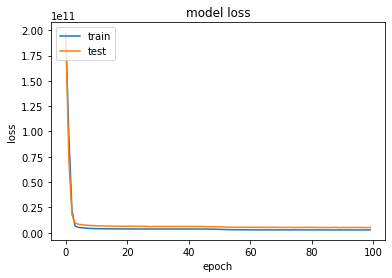

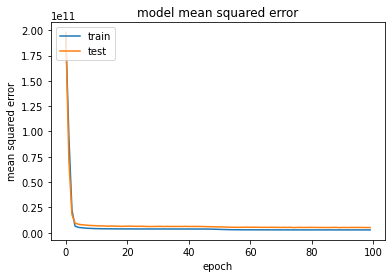

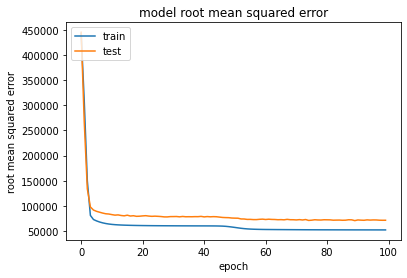

In [221]:
plt.figure(1)
plt.plot(regression_model_results[0].history['loss'])
plt.plot(regression_model_results[0].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(2)
plt.plot(regression_model_results[0].history['mean_squared_error'])
plt.plot(regression_model_results[0].history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(3)
plt.plot(regression_model_results[0].history['root_mean_squared_error'])
plt.plot(regression_model_results[0].history['val_root_mean_squared_error'])
plt.title('model root mean squared error')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [222]:
def epoch_with_lowest_test_error(removed_feature_model):
    epoch_number = np.argmin(removed_feature_model.history['val_loss'])
    val_r2_value = removed_feature_model.history['val_r2_score'][epoch_number]
    r2_value = removed_feature_model.history['r2_score'][epoch_number]

    print("The training epoch with lowest test loss is: ",epoch_number)
    print("The values for train r2: ",r2_value)
    print("The value for validation r2: ",val_r2_value)

In [225]:
epoch_with_lowest_test_error(regression_model_results[0])

The training epoch with lowest test loss is:  89
The values for train r2:  0.8824986815452576
The value for validation r2:  0.8043097853660583


In [232]:
print("The model results :")
print("train loss: ",min(regression_model_results[0].history['loss']))
print("validation loss: ",min(regression_model_results[0].history['val_loss']))
print("train MSE: ",min(regression_model_results[0].history['mean_squared_error']))
print("validation MSE: ",min(regression_model_results[0].history['val_mean_squared_error']))
print("train RMSE: ",min(regression_model_results[0].history['root_mean_squared_error']))
print("validation RMSE: ",min(regression_model_results[0].history['val_root_mean_squared_error']))
print("train r2 value: ",max(regression_model_results[0].history['r2_score']))
print("validation r2 value: ",max(regression_model_results[0].history['val_r2_score']))

The model results :
train loss:  2724137216.0
validation loss:  4991831552.0
train MSE:  2724137216.0
validation MSE:  4991831552.0
train RMSE:  52193.26953125
validation RMSE:  70652.8984375
train r2 value:  0.8830042481422424
validation r2 value:  0.8043097853660583


In [226]:
regression_model_results[1].load_weights("/Users/abhishekvaidyanathan/Desktop/NNDL/Neural-Networks-and-Deep-Learning/checkpoint.tf")

In [227]:
predictions = regression_model_results[1].predict(test_ds)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


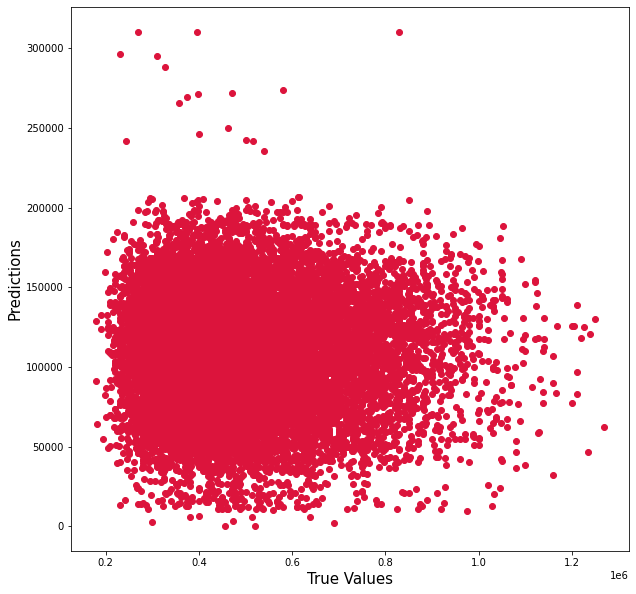

In [239]:
plt.figure(figsize=(10,10))
plt.scatter(np.concatenate([y for x, y in test_ds], axis=0), predictions, c='crimson')

plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
# plt.axis('equal')
plt.show()

### **QUESTION 2**

In [245]:
def regression_model_embedding_layer():
    x = layers.Dense(81, activation="relu")(all_features)
    x = layers.Embedding(81,81//2)(x)
    output = layers.Dense(1, activation="linear")(x)
    model = keras.Model(all_inputs, output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.05)
    model.compile(opt, tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError(),r2_score])

    keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='/Users/abhishekvaidyanathan/Desktop/NNDL/Neural-Networks-and-Deep-Learning/checkpoint.tf',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    history = model.fit(train_ds, epochs=100, validation_data=test_ds,callbacks=[model_checkpoint_callback])

    return [history,model]

In [246]:
regression_model_embedding_results = regression_model_embedding_layer()

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 6s 4ms/step - loss: 188980887552.0000 - mean_squared_error: 188980887552.0000 - root_mean_squared_error: 434719.3125 - r2_score: -658.3433 - val_loss: 178478039040.0000 - val_mean_squared_error: 178478039040.0000 - val_root_mean_squared_error: 422466.6562 - val_r2_score: -565.0380
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 77662920704.0000 - mean_squared_error: 77662920704.0000 - root_mean_squared_error: 278680.7500 - r2_score: -268.3522 - val_loss: 57094115328.0000 - val_mean_squared_error: 57094115328.0000 - val_root_mean_squared_error: 238943.7188 - val_r2_score: -178.2961
Epoch 3/100
683/683 [==============================] - 3s 3ms/step - loss: 27497222144.0000 - mean_squared_error: 27497222144.0000 - root_mean_squared_error: 165822.7656 - r2_score: -93.2308 - val_loss: 31187957760.0000 - val_mean_squared_error: 31187957760.0000 - val_root_mean_squared_error: 176601.1094 - val_r2_score: -96.3913
Epoch 4/100

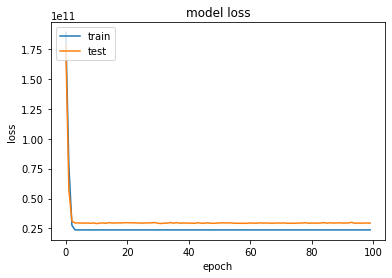

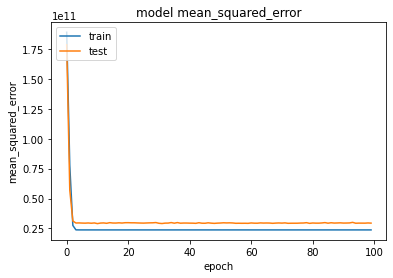

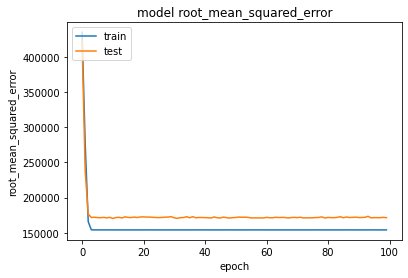

In [247]:
plt.figure(1)
plt.plot(regression_model_embedding_results[0].history['loss'])
plt.plot(regression_model_embedding_results[0].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(2)
plt.plot(regression_model_embedding_results[0].history['mean_squared_error'])
plt.plot(regression_model_embedding_results[0].history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(3)
plt.plot(regression_model_embedding_results[0].history['root_mean_squared_error'])
plt.plot(regression_model_embedding_results[0].history['val_root_mean_squared_error'])
plt.title('model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [249]:
epoch_with_lowest_test_error(regression_model_embedding_results[0])

The training epoch with lowest test loss is:  10
The values for train r2:  -80.60679626464844
The value for validation r2:  -89.66466522216797


In [248]:
print("The model results when the feature "+str(key)+" is removed")
print("train loss: ",min(regression_model_embedding_results[0].history['loss']))
print("validation loss: ",min(regression_model_embedding_results[0].history['val_loss']))
print("train MSE: ",min(regression_model_embedding_results[0].history['mean_squared_error']))
print("validation MSE: ",min(regression_model_embedding_results[0].history['val_mean_squared_error']))
print("train RMSE: ",min(regression_model_embedding_results[0].history['root_mean_squared_error']))
print("validation RMSE: ",min(regression_model_embedding_results[0].history['val_root_mean_squared_error']))
print("train r2 value: ",max(regression_model_embedding_results[0].history['r2_score']))
print("validation r2 value: ",max(regression_model_embedding_results[0].history['val_r2_score']))

The model results when the feature floor_area_sqm is removed
train loss:  23756976128.0
validation loss:  29035722752.0
train MSE:  23756976128.0
validation MSE:  29035722752.0
train RMSE:  154133.0
validation RMSE:  170398.71875
train r2 value:  -80.50497436523438
validation r2 value:  -89.66466522216797


### **QUESTION 3**

In [250]:
def regression_model_embedding_layer_early_stopping():
    x = layers.Dense(81, activation="relu")(all_features)
    x = layers.Embedding(81,81//2)(x)
    output = layers.Dense(1, activation="linear")(x)
    model = keras.Model(all_inputs, output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.05)
    model.compile(opt, tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError()])

    keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(train_ds, epochs=100, validation_data=test_ds,callbacks=[callback])

    return [history,model]

In [251]:
regression_model_early_stopping = regression_model_embedding_layer_early_stopping()

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Epoch 1/100
683/683 [==============================] - 6s 4ms/step - loss: 188863397888.0000 - mean_squared_error: 188863397888.0000 - root_mean_squared_error: 434584.2188 - val_loss: 178394382336.0000 - val_mean_squared_error: 178394382336.0000 - val_root_mean_squared_error: 422367.6250
Epoch 2/100
683/683 [==============================] - 3s 3ms/step - loss: 77653794816.0000 - mean_squared_error: 77653794816.0000 - root_mean_squared_error: 278664.3750 - val_loss: 57189871616.0000 - val_mean_squared_error: 57189871616.0000 - val_root_mean_squared_error: 239144.0625
Epoch 3/100
683/683 [==============================] - 3s 3ms/step - loss: 27476842496.0000 - mean_squared_error: 27476842496.0000 - root_mean_squared_error: 165761.4219 - val_loss: 31104813056.0000 - val_mean_squared_error: 31104813056.0000 - val_root_mea

In [14]:
features = [
    month_encoded,
    storey_range_encoded,
    flat_model_type_encoded,
    dist_to_nearest_stn_encoded,
    dist_to_dhoby_encoded,
    degree_centrality_encoded,
    eigenvector_centrality_encoded,
    remaining_lease_years_encoded,
    floor_area_sqm_encoded
]

feature_names = [
    "month",
    "storey_range",
    "flat_model_type",
    "dist_to_nearest_stn",
    "dist_to_dhoby",
    "degree_centrality",
    "eigenvector_centrality",
    "remaining_lease_years",
    "floor_area_sqm"
]

In [15]:
def regression_model_embedding_layer_removed_features(all_features,feature_name):
    x = layers.Dense(all_features.shape[1], activation="relu")(all_features)
    x = layers.Embedding(all_features.shape[1],(all_features.shape[1])//2)(x)
    output = layers.Dense(1, activation="linear")(x)
    model = keras.Model(all_inputs, output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.05)
    model.compile(opt, tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError(),r2_score])

    keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
    print("")
    print("Model training when feature "+str(feature_name)+" is removed.")
    print("")
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(train_ds, epochs=3, validation_data=test_ds,callbacks=[callback])

    return [history,model]

In [42]:
def rfe(feature_list,feature_names,minimum_val_loss):
    print("length of features:",len(feature_list))
    removed_feature = {}
    removed_feature_list = {}
    removed_feature_name = {}
    for i in range(len(feature_list)):
        features_list_new = feature_list[:i]+feature_list[i+1:]
        features_names_new = feature_names[:i]+feature_names[i+1:]
        removed_feature_name[feature_names[i]] = features_names_new
        removed_feature_list[feature_names[i]] = features_list_new
        features_list_concatenate = layers.concatenate(features_list_new)
        removed_feature[feature_names[i]] = min(regression_model_embedding_layer_removed_features(features_list_concatenate,feature_names[i])[0].history['val_loss'])
    minimum_loss = minimum_val_loss
    minimum = 10000000000000000000000000
    min_key = 1
    for key in removed_feature:
        print(removed_feature[key])
        if(removed_feature[key]<minimum):
            minimum = removed_feature[key]
            min_key = key
    if(minimum<minimum_loss and len(removed_feature_list[min_key])>1):
        minimum_loss = minimum
        rfe(removed_feature_list[min_key],removed_feature_name[min_key],minimum_loss)
    return removed_feature


In [44]:
rfe(features,feature_names,1000000000000000000000000)

length of features: 9
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')

Model training when feature month is removed.

Epoch 1/3


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 5s 5ms/step - loss: 193017413632.0000 - mean_squared_error: 193017413632.0000 - root_mean_squared_error: 439337.7812 - r2_score: -564.3734 - val_loss: 190703747072.0000 - val_mean_squared_error: 190703747072.0000 - val_root_mean_squared_error: 436696.3125 - val_r2_score: -505.6812
Epoch 2/3
683/683 [==============================] - 3s 3ms/step - loss: 89404399616.0000 - mean_squared_error: 89404399616.0000 - root_mean_squared_error: 299005.7500 - r2_score: -259.4322 - val_loss: 69312577536.0000 - val_mean_squared_error: 69312577536.0000 - val_root_mean_squared_error: 263272.7812 - val_r2_score: -182.0357
Epoch 3/3
683/683 [==============================] - 3s 3ms/step - loss: 30941282304.0000 - mean_squared_error: 30941282304.0000 - root_mean_squared_error: 175901.3594 - r2_score: -88.0948 - val_loss: 33081227264.0000 - val_mean_squared_error: 33081227264.0000 - val_root_mean_squared_error: 181882.4375 - val_r2_score: -85.6723
('You must inst

{'month': 33081227264.0,
 'storey_range': 34747314176.0,
 'flat_model_type': 59234287616.0,
 'dist_to_nearest_stn': 31177058304.0,
 'dist_to_dhoby': 31210487808.0,
 'degree_centrality': 31218661376.0,
 'eigenvector_centrality': 31191259136.0,
 'remaining_lease_years': 31109179392.0,
 'floor_area_sqm': 31200790528.0}

In [254]:
removed_feature = {}
for i in range(len(features)):
    features_list = features[:i]+features[i+1:]
    all_features_removed = layers.concatenate(features_list)
    removed_feature[feature_names[i]] = regression_model_embedding_layer_removed_features(all_features_removed,feature_names[i])    

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')

Model training when feature month is removed.

Epoch 1/3
683/683 [==============================] - 5s 4ms/step - loss: 193048576000.0000 - mean_squared_error: 193048576000.0000 - root_mean_squared_error: 439372.8750 - r2_score: -565.3038 - val_loss: 190763401216.0000 - val_mean_squared_error: 190763401216.0000 - val_root_mean_squared_error: 436764.6875 - val_r2_score: -506.1819
Epoch 2/3
683/683 [==============================] - 2s 3ms/step - loss: 89330909184.0000 - mean_squared_error: 89330909184.0000 - root_mean_squared_error: 298882.9062 - r2_score: -259.2108 - val_loss: 69203181568.0000 - val_mean_squared_error: 69203181568.0000 - val_root_mean_squared_error: 263065.0000 - val_r2_score: -182.5953
Epoch 3/3
683/683 [==============================] - 2s 3ms/step - loss: 30851330048.0000 - mean_squared_error: 3085

In [255]:
for key in removed_feature:
    print("The model results when the feature "+str(key)+" is removed")
    print("train loss: ",min(removed_feature[key][0].history['loss']))
    print("validation loss: ",min(removed_feature[key][0].history['val_loss']))
    print("train MSE: ",min(removed_feature[key][0].history['mean_squared_error']))
    print("validation MSE: ",min(removed_feature[key][0].history['val_mean_squared_error']))
    print("train RMSE: ",min(removed_feature[key][0].history['root_mean_squared_error']))
    print("validation RMSE: ",min(removed_feature[key][0].history['val_root_mean_squared_error']))
    print("train r2 value: ",max(removed_feature[key][0].history['r2_score']))
    print("validation r2 value: ",max(removed_feature[key][0].history['val_r2_score']))
    print("")

The model results when the feature month is removed
train loss:  30851330048.0
validation loss:  33003814912.0
train MSE:  30851330048.0
validation MSE:  33003814912.0
train RMSE:  175645.484375
validation RMSE:  181669.53125
train r2 value:  -88.0613784790039
validation r2 value:  -85.44995880126953

The model results when the feature storey_range is removed
train loss:  33651365888.0
validation loss:  34700091392.0
train MSE:  33651365888.0
validation MSE:  34700091392.0
train RMSE:  183443.109375
validation RMSE:  186279.578125
train r2 value:  -88.66057586669922
validation r2 value:  -83.37429809570312

The model results when the feature flat_model_type is removed
train loss:  62161260544.0
validation loss:  59206201344.0
train MSE:  62161260544.0
validation MSE:  59206201344.0
train RMSE:  249321.5625
validation RMSE:  243323.28125
train r2 value:  -97.30109405517578
validation r2 value:  -84.09158325195312

The model results when the feature dist_to_nearest_stn is removed
train l

Removing the feature remaining lease years has the lowest validation RMSE. Therefore it can be concluded that removing this feature helps improves the model. 

In [256]:
epoch_with_lowest_test_error(removed_feature["remaining_lease_years"][0])

The training epoch with lowest test loss is:  2
The values for train r2:  -91.97148895263672
The value for validation r2:  -94.94651794433594
